In [186]:
import json
import pandas as pd
import glob
import os
import re
import ast
import numpy as np
from collections import Counter

In [225]:
##### load Odin extractions #####

combined_ie = pd.read_csv("combined_data_ie_label.csv")
ie_extraction = combined_ie[['message_id', 'participant', 'start_timestamp', 'end_timestamp', 'ie_extraction']]
ie_extraction.set_index("message_id", inplace=True)

In [226]:
len(ie_extraction)

6727

In [227]:
####### Read in annotation ######

def readAnn(dir):
    dataAll_df = pd.read_csv(dir,index_col=None, header=0).\
        fillna("NA")\
        [["message_id", "Label", "Score", "Category", "Note"]]
    # exclude pre-game and post-game lines
    # exclude no annnotation lines
    data = dataAll_df[dataAll_df["Note"] == "NA"]\
                [["message_id", "Label", "Score", "Category"]]
    return data

In [228]:
dir_csv = glob.glob(os.path.join("CLC_annotation_MultiCat", 
                                "*.csv"))
dir_csv.sort()

dfs = (readAnn(dir) for dir in dir_csv)
ann_df = pd.concat(dfs, ignore_index=True)
ann_df.set_index("message_id", inplace=True)

In [229]:
len(ann_df)

6542

In [230]:
# match the message_id in ie_extraction with ann_df 
# to include only the annotated utterances

# select items in message_id which index appears in ann_df
ie_extraction = ie_extraction[ie_extraction.index.isin(ann_df.index)]
ie_extraction = ie_extraction[~ie_extraction.index.duplicated(keep='first')]
ann_df = ann_df[ann_df.index.isin(ie_extraction.index)]

# reset index
ie_extraction.reset_index(inplace=True)
ann_df.reset_index(inplace=True)


In [231]:
len(ann_df)

4929

In [232]:
# convert the dataframe to iterable list
list_ie_data = ie_extraction.values.tolist()

# read callout, checkback, and closing labelset
with open('label_selection.json', 'r') as file:
    label_selection = json.load(file)
callout_selection = label_selection["callout_selection"]
checkback_selection = label_selection["checkback_selection"]
closing_selection = label_selection["closing_selection"]

In [233]:
######## CLC extraction #######

def extract_clc(list_ie_data, win_size):
    '''This function takes the nested list of the data (message_id, participant, ie_extraction),
    and output the extracted clc event 
    eg.{turn_1:{message_id: 'a'}, turn_2:{message_id:'a', message_id:'b'}'''

    # Create a dict to store the clc extraction
    clc_extraction = {}

    for n in range(len(list_ie_data) - win_size):
        # Get the n:n+win_size window
        window = list_ie_data[n : n + win_size]
        
        # Find a
        message_id, participant, start, end, ie_extraction = list_ie_data[n]
        if not start == start: start = end
        is_a = False
        if ie_extraction == ie_extraction:
            for label in ie_extraction.split(', '):
                if label in callout_selection:
                    is_a = True
        if is_a:
            clc_extraction[n] = {message_id: 'a'}
            # Find b
            for item in window[1:]:
                next_id, next_participant, next_start, next_end, next_ie = item
                is_b = False
                if not next_start == next_start: next_start = next_end
                if next_participant != participant and next_start > start:
                    if next_ie == next_ie:
                        for label in next_ie.split(', '):
                            if label in checkback_selection:
                                is_b = True
                if is_b:
                    clc_extraction[n][next_id] = 'b'
                    start = next_start # deal with the situation that c occurs before b
            # Find c
            if is_b:
                for item in window[1:]:
                    next_id, next_participant, next_start, next_end, next_ie = item
                    is_c = False
                    if not next_start == next_start: next_start = next_end
                    if next_participant == participant and next_start > start:
                        if next_ie == next_ie:
                            for label in next_ie.split(', '):
                                if label in closing_selection:
                                    is_c = True
                    if is_c:
                        clc_extraction[n][next_id] = 'c'
    return clc_extraction

In [296]:
clc_extraction = extract_clc(list_ie_data, 5)

In [297]:
####### Evaluation #######

# For each utt, label the utt with CLC event labels
# {utt_1: CLC_event}
# possible situations for CLC_event: [NaN, a, ab, abb, abbb, abc, abbc, abbbc]


In [298]:
#### Get all utt #####

utts = ann_df["message_id"].to_list()

In [299]:
# convert clc_extraction to format {message_id_of_a:abbc}
clc_extraction_converted = {}

for extractions in clc_extraction.values():
    extractions = list(extractions.items())
    clc_extraction_converted[extractions[0][0]] = "".join([i[1] for i in extractions])

In [300]:
extraction = {}

for m_id in utts:
    if m_id in clc_extraction_converted:
        extraction[m_id] = clc_extraction_converted[m_id]
    else:
        extraction[m_id] = "NA"
extraction 

{'ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6': 'abbc',
 'f9ba47ea-6aef-450f-9d56-8486c2d38b11': 'ab',
 '2eb63755-e786-4fda-ad8e-e9e4328f34c5': 'NA',
 'a467ecae-10f8-4ebb-896e-e42612fa7e79': 'ab',
 '64d85e13-01b4-4b8d-902a-65955c2e0ea3': 'a',
 '0476e2e8-6ad5-4673-9f1f-4337564c42da': 'abb',
 'ca90eeb7-4d6a-4907-870d-d3b11f114b95': 'ab',
 'b35f95ad-9738-4ae1-bedf-472b0a0eff23': 'NA',
 '64e8126b-929e-4dcc-a076-31764932f907': 'abb',
 '05fa19bd-4aa2-406a-bafb-86438bf13780': 'NA',
 '76eb6a53-1d72-48d9-a5d8-e916d82e7ac2': 'NA',
 '8e31e138-b149-4f66-ac41-f5468a289c27': 'abb',
 '03d68c61-77b0-4521-8f5e-07fc4d525dc5': 'a',
 '3ecb1034-5152-4dd2-a46f-efdc67b54e8a': 'NA',
 'ae27fabf-c6eb-44f0-a606-cf019151652c': 'a',
 '5915da6c-ee19-413e-8ece-b0f776cb911d': 'abb',
 '446d8bdf-74a3-4f0a-a9b8-439b683a0c91': 'a',
 'b779bc04-0149-4632-a618-8e5424404b65': 'ab',
 '406ff6ef-3355-45c3-bcde-28747f4b9f96': 'ab',
 'fa116b70-5c3d-40ca-ad9e-fb7598b92e20': 'NA',
 'b066619a-5f1d-479e-b320-7cb7944f869b': 'abb',
 'aaeb5f49

In [301]:
# convert ann_df to dictionary
ann_dict = dict(zip(ann_df.message_id, ann_df.Label))


In [302]:
def convert_ann(ann_dict):
    '''Convert {message_id:1a.2b} to {turn_id:{message_id:a, message_id:b}}'''
    converted_ann = {}
    for item in ann_dict.items():
        m_id, clc_labels = item
        clc_labels = [i.rstrip("+") for i in clc_labels.split(".")]
        for label in clc_labels:
            if label != "NA" and label.strip():
                label = re.sub(r"(?<=[a-zA-Z]).*$", "", label)
                turn_id, label = re.findall(r'\d+|\D+', label)
                if turn_id not in converted_ann:
                    converted_ann[turn_id] = {m_id: label}
                else:
                    converted_ann[turn_id][m_id] = label
    return converted_ann

In [303]:
converted_ann = convert_ann(ann_dict)

In [304]:
# convert converted_ann to format {message_id_of_a:abbc}
ann_m_id_as_key = {}

for extractions in converted_ann.values():
    extractions = list(extractions.items())
    a_m_id = ""
    for item in extractions:
        m_id, phase = item
        if phase == "a":
            a_m_id = m_id
            ann_m_id_as_key[a_m_id] = phase
        else: ann_m_id_as_key[a_m_id] += phase
ann_m_id_as_key       


{'ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6': 'ab',
 'faac99f1-8d5d-45d2-892d-cc54acae7bde': 'abbc',
 'd87895e5-2162-4e82-9310-b04deb1da5b7': 'a',
 '8064b211-4a69-4aba-bef9-1a138a4d6792': 'ab',
 '469f9ba6-c020-441a-8b0c-bcb2d805a03d': 'ab',
 '11a735d7-6f20-492a-833c-0550e786d75a': 'a',
 'cddd5bd5-1b9a-4949-a973-f9f2f04f39cc': 'ab',
 '7b90a5a2-60a3-4d4c-b933-b696ec09fe56': 'ab',
 'e5fb8ffe-2980-42b3-b764-f59afab261a3': 'ab',
 '021092dc-0536-41ea-a1e9-4f0a3c24f312': 'abc',
 'fc971952-79d7-4b87-9983-81670539fd06': 'abc',
 '7505b127-e648-4ebe-881a-ee2c6d6d7e18': 'a',
 '71fe0dfd-a11d-4fb8-aa02-58041f6632a8': 'ab',
 '725759f8-b1dd-49f8-8980-3947f946fce3': 'a',
 '8e1a2cd8-2d6e-484a-a5a0-f9dba5e8a579': 'ab',
 '5e2080bd-a1bf-4eef-8c7d-f8dde0a7e836': 'ab',
 'f63bc38f-6229-470c-8572-3855566c33e3': 'a',
 'd90731e2-0448-44ab-9c7a-8be902f5c7c0': 'abcb',
 '13c5c2f9-81e7-43d2-bb22-e78d09bd89ce': 'a',
 'd23427cd-fb44-45b8-9aa9-1ee19cdf047b': 'ab',
 'f385982c-c876-4a5f-977e-601044dc0d06': 'ab',
 'b42e3645-db

In [305]:
# Align the ann_m_id_as_key with all utterance

ann = {}
for m_id in utts:
    if m_id in ann_m_id_as_key:
        ann[m_id] = ann_m_id_as_key[m_id]
    else:
        ann[m_id] = "NA"
ann

{'ce97fd05-3d0d-4e6c-b9fd-4c8ecf6d6fc6': 'ab',
 'f9ba47ea-6aef-450f-9d56-8486c2d38b11': 'a',
 '2eb63755-e786-4fda-ad8e-e9e4328f34c5': 'ab',
 'a467ecae-10f8-4ebb-896e-e42612fa7e79': 'ab',
 '64d85e13-01b4-4b8d-902a-65955c2e0ea3': 'NA',
 '0476e2e8-6ad5-4673-9f1f-4337564c42da': 'ab',
 'ca90eeb7-4d6a-4907-870d-d3b11f114b95': 'NA',
 'b35f95ad-9738-4ae1-bedf-472b0a0eff23': 'NA',
 '64e8126b-929e-4dcc-a076-31764932f907': 'abb',
 '05fa19bd-4aa2-406a-bafb-86438bf13780': 'NA',
 '76eb6a53-1d72-48d9-a5d8-e916d82e7ac2': 'NA',
 '8e31e138-b149-4f66-ac41-f5468a289c27': 'a',
 '03d68c61-77b0-4521-8f5e-07fc4d525dc5': 'NA',
 '3ecb1034-5152-4dd2-a46f-efdc67b54e8a': 'NA',
 'ae27fabf-c6eb-44f0-a606-cf019151652c': 'NA',
 '5915da6c-ee19-413e-8ece-b0f776cb911d': 'NA',
 '446d8bdf-74a3-4f0a-a9b8-439b683a0c91': 'NA',
 'b779bc04-0149-4632-a618-8e5424404b65': 'abc',
 '406ff6ef-3355-45c3-bcde-28747f4b9f96': 'NA',
 'fa116b70-5c3d-40ca-ad9e-fb7598b92e20': 'NA',
 'b066619a-5f1d-479e-b320-7cb7944f869b': 'NA',
 'aaeb5f49-c8

In [306]:
# Combine the extraction df and ann df
combined_dict = {k: [ann[k], extraction[k]] for k in ann}

# create a dataframe from the combined dictionary
combined_df = pd.DataFrame.from_dict(combined_dict, orient='index', columns=['ann', 'extraction'])


In [307]:
ann_list = combined_df["ann"].to_list()
extraction_list = combined_df["extraction"].to_list()

In [308]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [332]:
def printConfusionMatrix(ann_list,extraction_list,
                        f_size = 12, t_size="large"):
    conf_matrix = confusion_matrix(y_true=ann_list, y_pred=extraction_list)
    fig, ax = plt.subplots(figsize=(f_size, f_size))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size= t_size)
    
    labels_unique = sorted(set(ann_list + extraction_list))
    tick_marks = np.arange(len(labels_unique))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels_unique, rotation=45)
    ax.set_yticklabels(labels_unique)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()


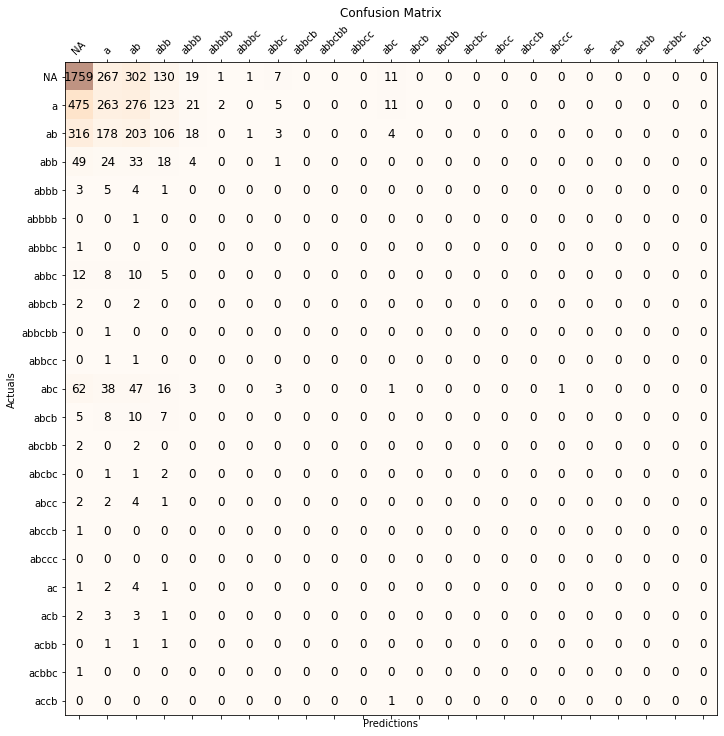

In [331]:
printConfusionMatrix(ann_list,extraction_list)

In [339]:
all_metrics = metrics.classification_report(ann_list, extraction_list, digits=3, zero_division=1)
print(all_metrics)

              precision    recall  f1-score   support

          NA      0.653     0.704     0.678      2497
           a      0.328     0.224     0.266      1176
          ab      0.225     0.245     0.234       829
         abb      0.044     0.140     0.067       129
        abbb      0.000     0.000     0.000        13
       abbbb      0.000     0.000     0.000         1
       abbbc      0.000     0.000     0.000         1
        abbc      0.000     0.000     0.000        35
       abbcb      1.000     0.000     0.000         4
      abbcbb      1.000     0.000     0.000         1
       abbcc      1.000     0.000     0.000         2
         abc      0.036     0.006     0.010       171
        abcb      1.000     0.000     0.000        30
       abcbb      1.000     0.000     0.000         4
       abcbc      1.000     0.000     0.000         4
        abcc      1.000     0.000     0.000         9
       abccb      1.000     0.000     0.000         1
       abccc      0.000    

In [340]:
#### Merge label categories to only have {NA, a, ab, abc}

# ab+ -> ab
# ab+c -> abc
# ab+c+ -> abc
# ab+c+b+ -> abc
# ac+b+ -> abc
# ac -> ab

In [341]:
ann_list[:10]

['ab', 'a', 'ab', 'ab', 'NA', 'ab', 'NA', 'NA', 'abb', 'NA']

In [342]:
def merge_labels(label_list):
    '''This function merges label categories to only have {NA, a, ab, abc}'''
    merged_list = []
    pattern = r"(.)\1*"
    for label in label_list:
        res_label = re.sub(pattern, r"\1", label)
        if res_label == "NA":
            merged_list.append(res_label)
        elif res_label == "a":
            merged_list.append("a")
        elif res_label == "ac":
            merged_list.append("ab")
        elif set(["a", "b","c"]).issubset(set(res_label)):
            merged_list.append("abc")
        else:
            merged_list.append("ab")
    return merged_list

merged_ann = merge_labels(ann_list)
merged_extraction = merge_labels(extraction_list)

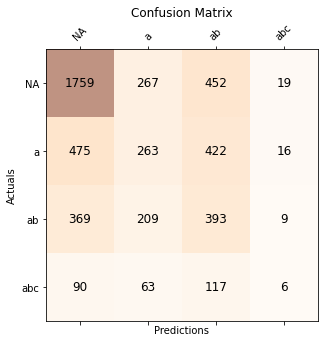

In [343]:
printConfusionMatrix(merged_ann,merged_extraction,f_size = 5)

In [344]:
overall = metrics.classification_report(merged_ann, merged_extraction, digits=3, zero_division=1)

In [345]:
print(overall)

              precision    recall  f1-score   support

          NA      0.653     0.704     0.678      2497
           a      0.328     0.224     0.266      1176
          ab      0.284     0.401     0.332       980
         abc      0.120     0.022     0.037       276

    accuracy                          0.491      4929
   macro avg      0.346     0.338     0.328      4929
weighted avg      0.472     0.491     0.475      4929

